# Maked Language Modelling with Code-BERT

In [15]:
from transformers import RobertaTokenizer, RobertaForMaskedLM, pipeline
import pandas as pd
import nltk
import random
import sys
import warnings
from matplotlib import pyplot as plt

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
# Snippet used to suppress a CodeBERT related warning
# warnings.filterwarnings("ignore", message="Some weights of the model checkpoint at .* were not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module="transformers.modeling_utils")

In [19]:
# Maintain a dictionary with the results of each experiment
exp_results = dict()

In [20]:
"""
    The MaskedModel class implements a framework for the conducted experiments, where by relying on a Tokenizer and Masker class
    it predicts the tokens of the mask and returns (by design) the predicted token with the highest probability value
"""
class MaskedModel:

  def __init__(self):
    self.model = RobertaForMaskedLM.from_pretrained('microsoft/codebert-base-mlm')
    self.tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base-mlm')
    self.fill_mask = None
    self.outputs = None
    self.code_example = None

  def setCodeExample(self, code):
    self.code_example = code

  def clearCodeExample(self):
    self.code_example = None

  """ Set up the experiment pipeline """
  def setUpMaskExperiment(self):
    self.fill_mask = pipeline('fill-mask', model=self.model, tokenizer=self.tokenizer)

  def fillMask(self):
    if self.code_example != None:
      self.outputs = self.fill_mask(self.code_example)
    else:
      print("code_example is set to None!")

  """ Sets up all the necessary dependencies and runs the experiment, returning the token with the highest probability """
  def startExperiment(self, code):
    self.setUpMaskExperiment()
    self.setCodeExample(code)
    self.fillMask()
    # This ugly looking conditional block is made because for some reason the outputs are not always the same (i.e. list of dict, some times it is a list of list of dict)
    # Weird issue block -- START --
    if type(self.outputs[0]) == type(list()):
      out = self.outputs[0][0]
    elif type(self.outputs[0]) == type(dict()):
      out = self.outputs[0]
    else:
      print("--- ERROR ---")
      sys.exit(-1)
    # Weird issue block -- FINISH --
    return out['token_str']

In [21]:
""" The class implements a tokenizer and masker for any given source file, it only masks one token per each run of the class """
class TokenMasker:

  def __init__(self, filePath):
    self.file_path = filePath
    self.masked_text = None
    self.masked_token = None

  def getMaskedToken(self):
    if self.masked_token == None:
      print("Error - The token hasn't been masked yet!")
    return self.masked_token

  def getMaskedText(self):
    if self.masked_text == None:
      print("Error, masked text is set to None")
    return self.masked_text

  def tokenize_and_mask(self):
      with open(self.file_path, 'r', encoding='utf-8') as file:
          text = file.read()

      tokens = nltk.word_tokenize(text)

      # Randomly select a token to mask
      token_to_mask = random.choice(tokens)
      self.masked_token = token_to_mask

      # Mask the selected token
      masked_tokens = [token if token != token_to_mask else '<mask>' for token in tokens]

      # Join the masked tokens back into a sentence
      masked_text = ' '.join(masked_tokens)
      self.masked_text = masked_text

## Experiments

The following is an example of how experiemtns using the specified model, are conducted based on the previously seen classes, MaskedModel and TokenMasker.

The experiment merely:

- Tokenizes and masks a token in a given source file
- Feeds the tokenized text with the mask to the Masked Model (CodeBERT in this case)
- Returns the predicted token with the highest probability value

In [22]:
# Sample Experiment

# Path of experimented source file
path = '/content/drive/MyDrive/Masked-Language-Model-Project/sample-00.py'

mlm = MaskedModel()
tkmskr = TokenMasker(path)

# Step 1 - Tokenize and Mask the source code
tkmskr.tokenize_and_mask()
masked_text = tkmskr.getMaskedText()

# Step 2 - Pass the masked tokenized text to the Masked Language Model
print("Masked Text:\t{}".format(masked_text))

# Step 3 - Retrieve the predicted token with the highest probability
token = mlm.startExperiment(masked_text)
m_token = tkmskr.getMaskedToken()
print("MLM Experiment Result:\t{}\t|\t Masked Token:\t{}".format(token, m_token))

# End of experiment

Some weights of the model checkpoint at microsoft/codebert-base-mlm were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Masked Text:	from matplotlib import pyplot as plt import numpy as np import pandas as pd for i in range ( 1000 ) : print ( <mask> Hello World '' ) def adder ( a , b ) : return ( a + b ) def subtractor ( a , b ) : return ( a - b ) X = np.linspace ( 0 , 100 ) np.random.seed ( 42 ) # Number of points to sample num_points = 100 # Generate random mean and standard deviation mean = np.random.uniform ( -5 , 5 ) std_dev = np.random.uniform ( 1 , 3 ) # Sample points from the Gaussian distribution samples = np.random.normal ( loc=mean , scale=std_dev , size=num_points ) # Plot the histogram of the samples plt.hist ( samples , bins=20 , density=True , alpha=0.7 , color='blue ' , edgecolor='black ' ) plt.title ( 'Random Samples from Gaussian Distribution ' ) plt.xlabel ( 'Value ' ) plt.ylabel ( 'Probability Density ' ) plt.grid ( True ) plt.show ( )
MLM Experiment Result:	 '	|	 Masked Token:	``


In [23]:
# Experiment Class

class Experiment:

  """ The ordered tuple is for a specific experiment """
  def __init__(self, path):
    self.token_masker = TokenMasker(path)
    self.masked_model = MaskedModel()

  def startExp(self, dataFrame):
    self.token_masker.tokenize_and_mask()
    m_token = self.token_masker.getMaskedToken()
    masked_text = self.token_masker.getMaskedText()
    token = self.masked_model.startExperiment(masked_text)
    # Remove the whitespace or else the comparrison doesn't work
    if m_token.strip() == token.strip():
      success = True
    else:
      success = False
    # Add the entry to the dataframe
    new_entry = {'Ground-Truth-Token': m_token, 'Predicted-Token': token, 'Success': success}
    dataFrame.loc[len(df)] = new_entry
    return dataFrame

In [ ]:
# Iteration of experiments

path = '/content/drive/MyDrive/Masked-Language-Model-Project/sample-00.py'
max_iter = 100

# Creating the Data Frame for the specific source file
df = pd.DataFrame(columns=['Ground-Truth-Token', 'Predicted-Token', 'Success'])

for i in range(max_iter):
  print("Iteration:\t{}".format(i))
  exp = Experiment(path)
  df = exp.startExp(df)

print('Experiments on <{}> completed'.format(path))

In [25]:
df

,Ground-Truth-Token,Predicted-Token,Success
0,pyplot,cm,False
1,),),True
2,np.random.normal,sample,False
3,samples,sample,False
4,bins=20,X,False
...,...,...,...
95,(,(,True
96,alpha=0.7,False,False
97,(,(,True
98,from,import,False


In [26]:
def getPercentage(result, df):
  return (100 * result) / len(df)

In [27]:
# Count the total number of successful predictions
result = df.sum(axis=1).sum()
print(result.sum())

# Experiment's results
print("Experiment Accuracy:\t{:.2f} %".format(getPercentage(result, df)))

66
Experiment Accuracy:	66.00 %


<ipython-input-27-1287f45db6d0>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result = df.sum(axis=1).sum()


## The Idea

The main idea to evaluate the currently trained CodeBERT performances is to run the experiments several times, on different masks each time, save the results into a Pandas DataFrame and evaluate the accuracy based on the used programming language

----

## Java Specific Application

By fine-tuning the model to certain Java code examples to check for a performance increase, potentially even with multiple masks placed in the source code

----

## Open Problems

Masked Language Models are used for a large variety of tasks in the field of Software Engineering, from Code Completion to Bug Fixing, an interesting approach would be that of automatically detecting bugs and propose an interesting solution to fix the bug, or a lighter and easier approach would be that of:

- Fine tuning the Masked Language Model to enterprise-level Java code
- Use a 'labelled' dataset (defets4j?) where the bugs are already masked
- Evaluate the performance of the fine-tuned model compared to the default model

----
(To be confirmed)
## Final Project for the Distributed Systems Engineering Course

- Create a SpringBoot-based app with 2 distinct microservices where one takes in a source file (written in Java) and the tokenizes it and randomly masks a token, only to then pass the tokenized data via a messagging queue such as RabbitMQ (or an event streaming software such as Apache Kafka), and another microservice (running the Masked Language Model) retrieves the tokenized data and makes a prediction on the retrieved masked and tokenized code, and measures the performance becasue the masked token will also be sent to the Masked Model Microservice (supervised learning style).

The 'app' is to be dockerized and optionally deployed to the docker hub and with other course-related features such as authentication-sessioning and with a DevOps pipeline (Good on resume)

By adding an MLOps portion, the project can be seen as an excellent point in one's resume!

## Simple Web Server code example

The following experiments show the behavior of the pre-trained CodeBERT MLM on
different flavors (programming languages) of a simple web server, and the preformances of them are measured across the Python, Java, JavaScript, Go, PHP and Ruby programming languages

In [ ]:
# Python code experiment

path = '/content/drive/MyDrive/Masked-Language-Model-Project/sample-01.py'
max_iter = 100

# Creating the Data Frame for the specific source file
df = pd.DataFrame(columns=['Ground-Truth-Token', 'Predicted-Token', 'Success'])

for i in range(max_iter):
  print("Iteration:\t{}".format(i))
  exp = Experiment(path)
  df = exp.startExp(df)

print('Experiments on <{}> completed'.format(path))

In [29]:
df

,Ground-Truth-Token,Predicted-Token,Success
0,),),True
1,),),True
2,port=8080,hello,False
3,:,:,True
4,return,print,False
...,...,...,...
95,hello,main,False
96,in,for,False
97,__name__,app,False
98,(,(,True


In [30]:
# Count the total number of successful predictions
python_result = df.sum(axis=1).sum()
print(python_result.sum())

# Experiment's results
print("Experiment Accuracy:\t{:.2f} %".format(getPercentage(python_result, df)))

# Save the experiment's result
exp_results['Python'] = python_result / 100

58
Experiment Accuracy:	58.00 %


<ipython-input-30-b2b3ec6e245b>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  python_result = df.sum(axis=1).sum()


In [ ]:
# Go code experiment
path = '/content/drive/MyDrive/Masked-Language-Model-Project/sample-02.go'
max_iter = 100

# Creating the Data Frame for the specific source file
df = pd.DataFrame(columns=['Ground-Truth-Token', 'Predicted-Token', 'Success'])

for i in range(max_iter):
  print("Iteration:\t{}".format(i))
  exp = Experiment(path)
  df = exp.startExp(df)

print('Experiments on <{}> completed'.format(path))

In [32]:
df

,Ground-Truth-Token,Predicted-Token,Success
0,Go,Go,True
1,handler,hello,False
2,Error,Error,True
3,!,!,True
4,for,for,True
...,...,...,...
95,running,listening,False
96,Start,Start,True
97,w,w,True
98,web,web,True


In [33]:
# Count the total number of successful predictions
go_result = df.sum(axis=1).sum()
print(go_result.sum())

# Experiment's results
print("Experiment Accuracy:\t{:.2f} %".format(getPercentage(go_result, df)))

# Save the experiment's result
exp_results['go'] = go_result / 100

47
Experiment Accuracy:	47.00 %


<ipython-input-33-2e490605534c>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  go_result = df.sum(axis=1).sum()


In [ ]:
# Java code experiment
path = '/content/drive/MyDrive/Masked-Language-Model-Project/sample-03.java'
max_iter = 100

# Creating the Data Frame for the specific source file
df = pd.DataFrame(columns=['Ground-Truth-Token', 'Predicted-Token', 'Success'])

for i in range(max_iter):
  print("Iteration:\t{}".format(i))
  exp = Experiment(path)
  df = exp.startExp(df)

print('Experiments on <{}> completed'.format(path))

In [35]:
df

,Ground-Truth-Token,Predicted-Token,Success
0,import,class,False
1,class,class,True
2,[,[,True
3,MyHandler,Context,False
4,{,{,True
...,...,...,...
95,200,response,False
96,public,static,False
97,(,(,True
98,throws,throws,True


In [36]:
# Count the total number of successful predictions
java_result = df.sum(axis=1).sum()
print(java_result.sum())

# Experiment's results
print("Experiment Accuracy:\t{:.2f} %".format(getPercentage(java_result, df)))

# Save the experiment's result
exp_results['java'] = java_result / 100

69
Experiment Accuracy:	69.00 %


<ipython-input-36-b3075b3ae443>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  java_result = df.sum(axis=1).sum()


In [ ]:
# JavaScript code experiment
path = '/content/drive/MyDrive/Masked-Language-Model-Project/sample-04.js'
max_iter = 100

# Creating the Data Frame for the specific source file
df = pd.DataFrame(columns=['Ground-Truth-Token', 'Predicted-Token', 'Success'])

for i in range(max_iter):
  print("Iteration:\t{}".format(i))
  exp = Experiment(path)
  df = exp.startExp(df)

print('Experiments on <{}> completed'.format(path))

In [38]:
df

,Ground-Truth-Token,Predicted-Token,Success
0,const,const,True
1,is,is,True
2,>,=>,False
3,is,is,True
4,Server,Server,True
...,...,...,...
95,",",",",True
96,(,(,True
97,;,;,True
98,(,(,True


In [39]:
# Count the total number of successful predictions
js_result = df.sum(axis=1).sum()
print(js_result.sum())

# Experiment's results
print("Experiment Accuracy:\t{:.2f} %".format(getPercentage(js_result, df)))

# Save the experiment's result
exp_results['js'] = js_result / 100

69
Experiment Accuracy:	69.00 %


<ipython-input-39-3ff27619e209>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  js_result = df.sum(axis=1).sum()


In [ ]:
# Ruby code example
path = '/content/drive/MyDrive/Masked-Language-Model-Project/sample-05.rb'
max_iter = 100

# Creating the Data Frame for the specific source file
df = pd.DataFrame(columns=['Ground-Truth-Token', 'Predicted-Token', 'Success'])

for i in range(max_iter):
  print("Iteration:\t{}".format(i))
  exp = Experiment(path)
  df = exp.startExp(df)

print('Experiments on <{}> completed'.format(path))

In [41]:
df

,Ground-Truth-Token,Predicted-Token,Success
0,:HTTPServer.new,Server,False
1,(,(,True
2,=,=,True
3,=,=,True
4,=,=,True
...,...,...,...
95,',',True
96,",",",",True
97,{,{,True
98,'Server,',False


In [42]:
# Count the total number of successful predictions
rb_result = df.sum(axis=1).sum()
print(rb_result.sum())

# Experiment's results
print("Experiment Accuracy:\t{:.2f} %".format(getPercentage(rb_result, df)))

# Save the experiment's result
exp_results['rb'] = rb_result / 100

49
Experiment Accuracy:	49.00 %


<ipython-input-42-afd46b0728c0>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rb_result = df.sum(axis=1).sum()


In [ ]:
# PHP code experiment
path = '/content/drive/MyDrive/Masked-Language-Model-Project/sample-06.php'
max_iter = 100

# Creating the Data Frame for the specific source file
df = pd.DataFrame(columns=['Ground-Truth-Token', 'Predicted-Token', 'Success'])

for i in range(max_iter):
  print("Iteration:\t{}".format(i))
  exp = Experiment(path)
  df = exp.startExp(df)

print('Experiments on <{}> completed'.format(path))

In [44]:
df

,Ground-Truth-Token,Predicted-Token,Success
0,while,while,True
1,$,$,True
2,OK\r\nContent-Type,OK,False
3,{,{,True
4,",",",",True
...,...,...,...
95,$,$,True
96,'',``,False
97,errstr,timeout,False
98,$,$,True


In [45]:
# Count the total number of successful predictions
php_result = df.sum(axis=1).sum()
print(php_result.sum())

# Experiment's results
print("Experiment Accuracy:\t{:.2f} %".format(getPercentage(php_result, df)))

# Save the experiment's result
exp_results['php'] = php_result / 100

57
Experiment Accuracy:	57.00 %


<ipython-input-45-a066017bbd63>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  php_result = df.sum(axis=1).sum()


In [46]:
# Move the results dictionary into a DataFrame so that it may be exported
dataFrame = pd.DataFrame(list(exp_results.items()), columns=['Language', 'Score'])
dataFrame

,Language,Score
0,Python,0.58
1,go,0.47
2,java,0.69
3,js,0.69
4,rb,0.49
5,php,0.57


(0.0, 1.0)

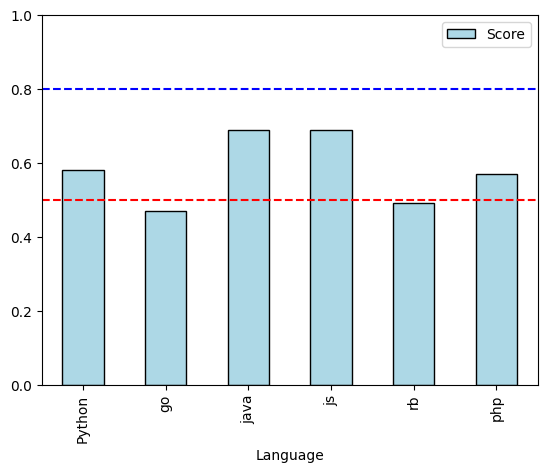

In [47]:
p = dataFrame.plot(x='Language', y='Score', kind='bar', color='lightblue', edgecolor='black')
# 50 % threshold
p.axhline(y=0.5, color='red', linestyle='--', label='Threshold')
# 80 % threshold
p.axhline(y=0.8, color='blue', linestyle='--', label='Threshold')
p.set_ylim(0, 1)

In [48]:
# Export the plot
output_plot_name = '/content/drive/MyDrive/Masked-Language-Model-Project/Graphed-Data/Pre-Trained-CodeBERT-preformance.png'
fig = p.get_figure()
fig.savefig(output_plot_name)

In [49]:
# Export the dataframe in .csv format
output_file_name = '/content/drive/MyDrive/Masked-Language-Model-Project/exp-data/pre-trained-CodeBERT-experiment-results.csv'
dataFrame.to_csv(output_file_name, index=False)
print("DataFrame exported!")

DataFrame exported!
